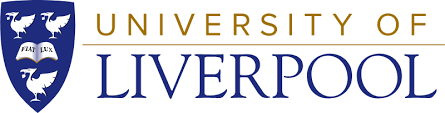

University of Liverpool - ION Switching Competition

**Objective**:  Use channel data to better model automatic identification methods and detect individual ion channel events in noisy raw signals.

**Data**: Discrete batch of 50 second long 10 kHz samples with 500,000 rows per batch.

**Load Libraries and Data**[](http://)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree
import seaborn as sns
import matplotlib.ticker as ticker


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-without-drift/train_clean.csv
/kaggle/input/data-without-drift/test_clean.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv
/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/train.csv


In [5]:
train = pd.read_csv(r'/kaggle/input/liverpool-ion-switching/train.csv')
test = pd.read_csv(r'/kaggle/input/liverpool-ion-switching/test.csv')
submission = pd.read_csv(r'/kaggle/input/liverpool-ion-switching/sample_submission.csv')
# Using the cleaned data without signal drift from Chris Deotte 
# https://www.kaggle.com/cdeotte/data-without-drift
test_clean = pd.read_csv(r'/kaggle/input/data-without-drift/test_clean.csv')
train_clean= pd.read_csv(r'/kaggle/input/data-without-drift/train_clean.csv')

Visualize the data

In [6]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [7]:
train.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


In [38]:
test.head()

,time,signal,batch
0,500.0001,-2.6498,1
1,500.0002,-2.8494,1
2,500.0003,-2.8600,1
3,500.0004,-2.4350,1
4,500.0005,-2.6155,1


In [39]:
submission.head()

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
time             float64
signal           float64
open_channels    int64
dtypes: float64(2), int64(1)
memory usage: 114.4 MB


## DATA

We are told there are 500,000 rows per batch. We have 5M rows so we have 10 batches in our training data.  Our test data consists of 4 batches.
We can view each batch together in the plot below.
We can also visually see the # of channels and signal strength together for each batch.**


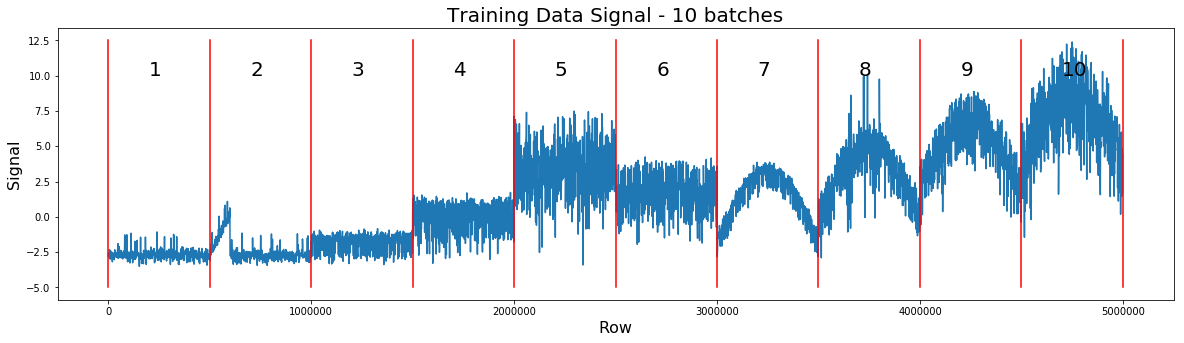

In [9]:
plt.figure(figsize=(20,5)); 
step = 1000
batch_size = 500000


plt.plot(range(0,train.shape[0],step),train.signal[0::step])

#Plot vertical bars
for i in range(11): 
    plt.plot([i*500000,i*500000],[-5,12.5],'r')
#Label the batches
for j in range(10): 
    plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); 
plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)

plt.show()

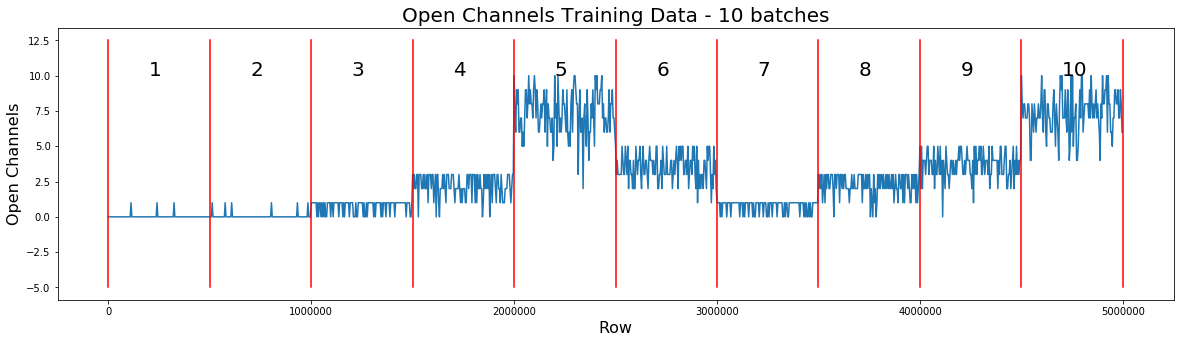

In [10]:
plt.figure(figsize=(20,5)); 
step = 4000

plt.plot(range(0,train.shape[0], step), train.open_channels[0::step])

#Plot vertical bars
for i in range(11): 
    plt.plot([i*500000,i*500000],[-5,12.5],'r')

#Label the batches
for j in range(10): 
    plt.text(j*500000+200000, 10,str(j+1), size = 20)

plt.xlabel('Row', size = 16);
plt.ylabel('Open Channels', size = 16);
plt.title('Open Channels Training Data - 10 batches', size = 20)
plt.show()

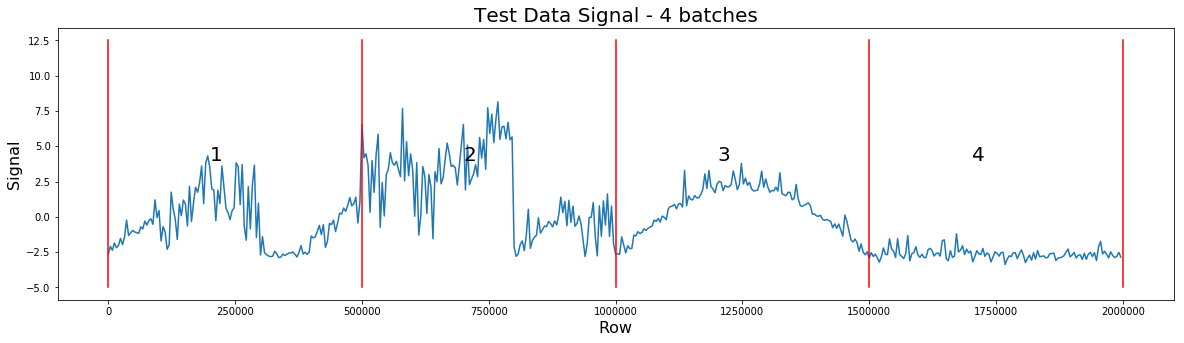

In [11]:
plt.figure(figsize=(20,5)); 
step = 4000

plt.plot(range(0,test.shape[0],step),test.signal[0::step])

#Plot vertical bars
for i in range(5): 
    plt.plot([i*500000,i*500000],[-5,12.5],'r')
#Label the batches
for j in range(4): 
    plt.text(j*500000+200000,4,str(j+1),size=20)

plt.xlabel('Row',size=16); 
plt.ylabel('Signal',size=16); 
plt.title('Test Data Signal - 4 batches',size=20)
plt.show()

View some statistics on each batch

In [12]:
def batch_labeler(rownum):
    x = int(np.ceil((rownum+1) / 500000.0))

    return x

In [23]:
train['batch'] = pd.Series(train.index).apply(batch_labeler)
train_clean['batch'] = pd.Series(train_clean.index).apply(batch_labeler)
test['batch']= pd.Series(test.index).apply(batch_labeler)
test_clean['batch']= pd.Series(test_clean.index).apply(batch_labeler)

In [24]:
train.groupby('batch').agg({'signal': [np.count_nonzero,np.max, np.min, np.mean, np.std],
                                      'open_channels':[np.count_nonzero,np.max, np.min, np.mean, np.std],
                           'time':[np.count_nonzero]})
train_clean.groupby('batch').agg({'signal': [np.count_nonzero,np.max, np.min, np.mean, np.std],
                                      'open_channels':[np.count_nonzero,np.max, np.min, np.mean, np.std],
                           'time':[np.count_nonzero]})
                                   

signal                                         open_channels  \
      count_nonzero      amax      amin      mean       std count_nonzero   
batch                                                                       
1          500000.0  4.999800 -3.850600 -2.681406  0.329630         15866   
2          500000.0  0.297600 -3.902100 -2.683105  0.345540         19338   
3          500000.0 -0.352500 -3.910700 -1.813125  0.590369        373996   
4          499976.0  2.240400 -3.707300 -0.092984  1.002793        488222   
5          499996.0  8.613100 -5.796500  3.357808  1.818265        499998   
6          499996.0  4.792900 -3.817400  1.680843  1.278658        499044   
7          500000.0 -0.285449 -3.902237 -1.803928  0.586192        376805   
8          500000.0  4.999897 -5.000055 -0.107861  1.170470        487546   
9          500000.0  4.643207 -3.657229  1.658963  1.284179        499033   
10         500000.0  8.515577 -4.997116  3.310907  1.818692        500000   

                                             time  
      amax amin      mean       std count_nonzero  
batch                                              
1        1    0  0.031732  0.175286      500000.0  
2        1    0  0.038676  0.192822      500000.0  
3        1    0  0.747992  0.434166      500000.0  
4        3    0  2.147846  0.784248      500000.0  
5       10    0  7.147186  1.435385      500000.0  
6        5    0  3.576684  1.008681      500000.0  
7        1    0  0.753610  0.430909      500000.0  
8        3    0  2.135186  0.789387      500000.0  
9        5    0  3.570304  1.011490      500000.0  
10      10    1  7.111216  1.436433      500000.0

From the table above, we can group the batches as follows:
1.      Group 1: Batch 1 & 2
        Both have low probability of open channels with <4% probability
        Max of 1 open channel 
        Similar average and standard deviation with .03 and ~.2 respectively.
2.      Group 2: Batch 3 and 7
        Both have similar probability of open channels with ~75% probability
        Max of 1 open channel 
        Similar average and standard deviation with .75 and ~.43 respectively.
3.      Group 3: Batch 4 and 8
        Both have similar probability of open channels with ~97.6% probability
        Max of 3 open channels
        Similar average and standard deviation with 2.1 and ~.78 respectively.
4.      Group 4: Batch 6 and 9
        Both have similar probability of open channels with ~99.8% probability
        Max of 5 open channels
        Similar average and standard deviation with 3.5 and ~1.01 respectively.
5.      Group 5: Batch 5 and 10
        Both have similar probability of open channels with ~99.99% probability
        Max of 10 open channels
        Similar average and standard deviation with 7.1 and ~1.43 respectively.

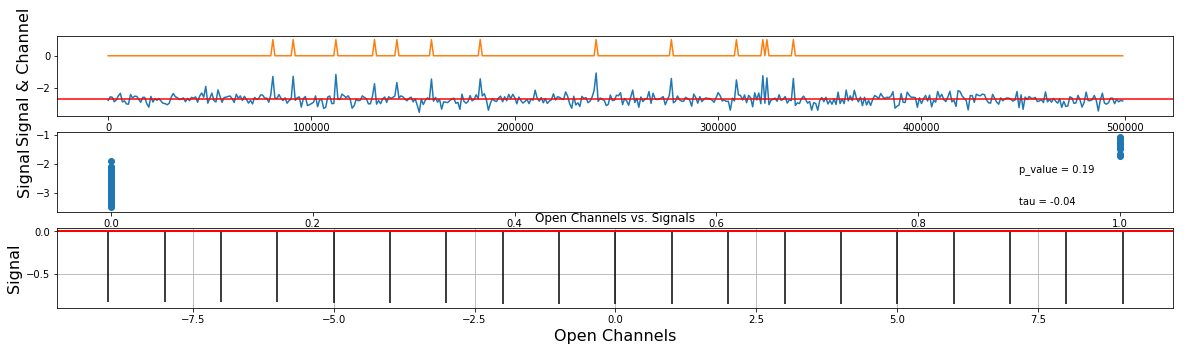

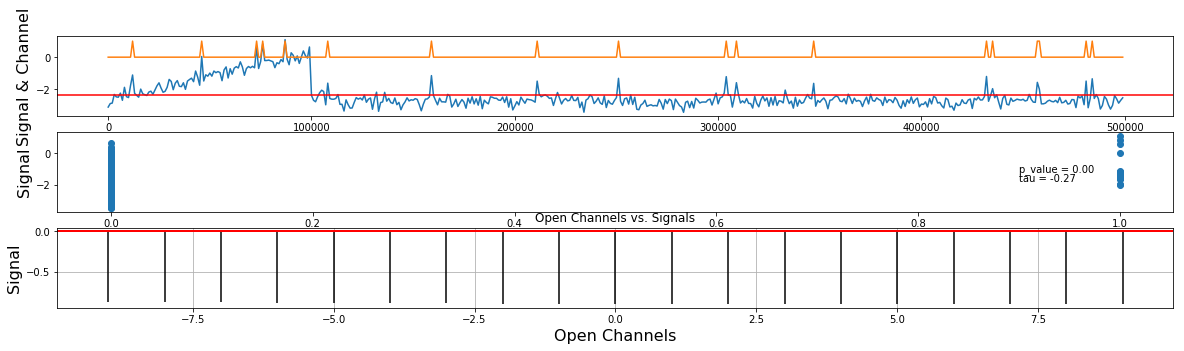

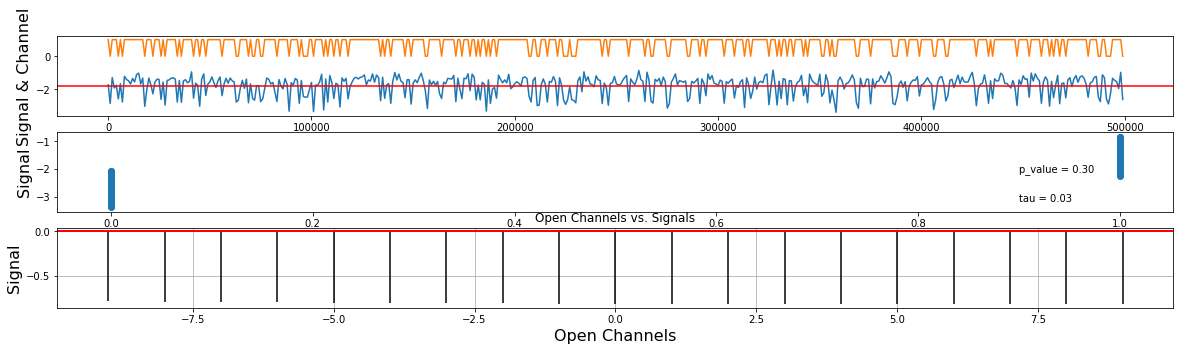

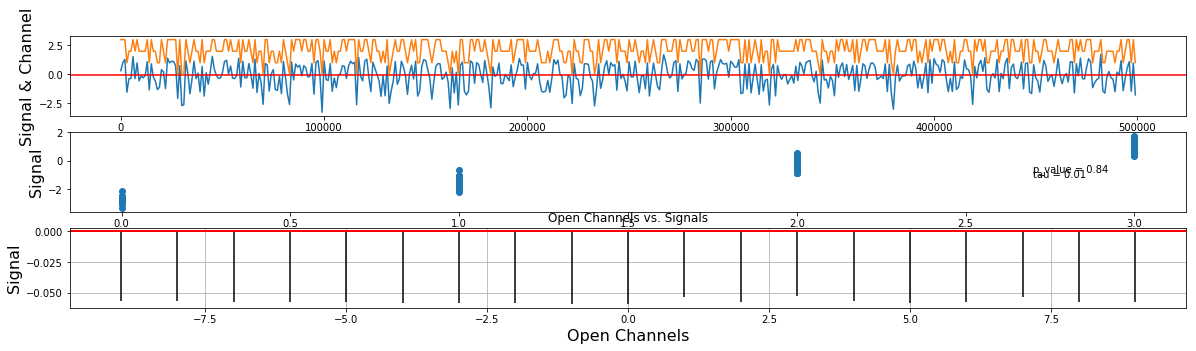

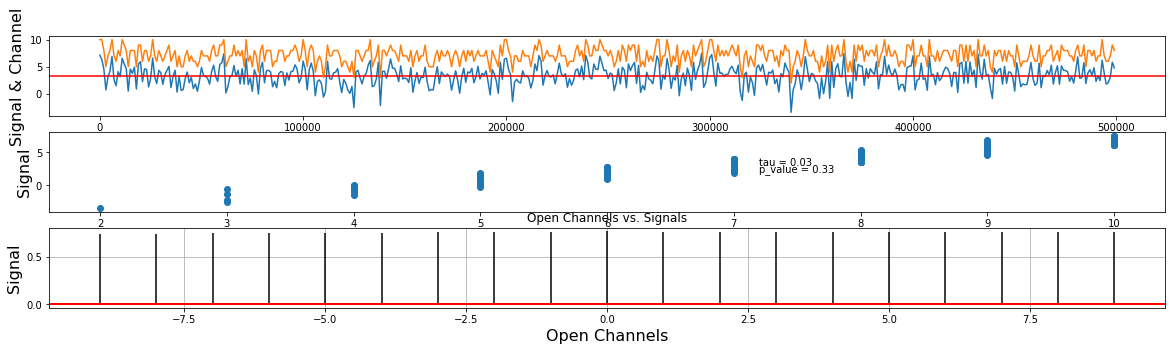

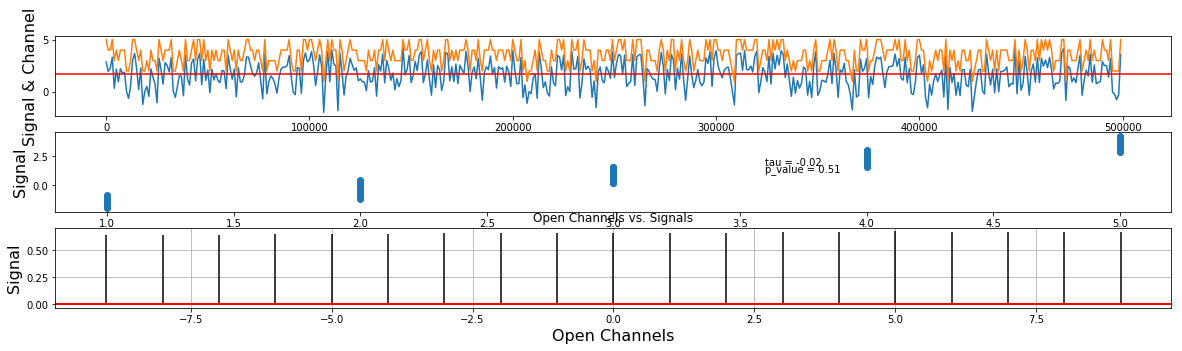

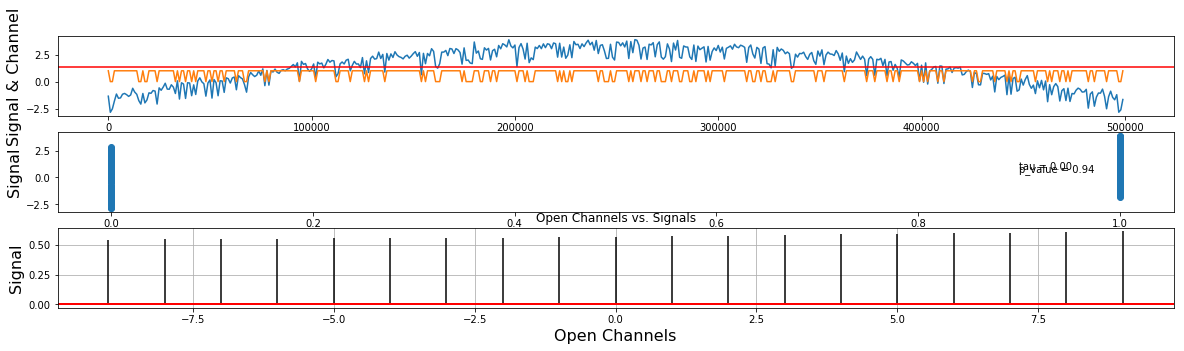

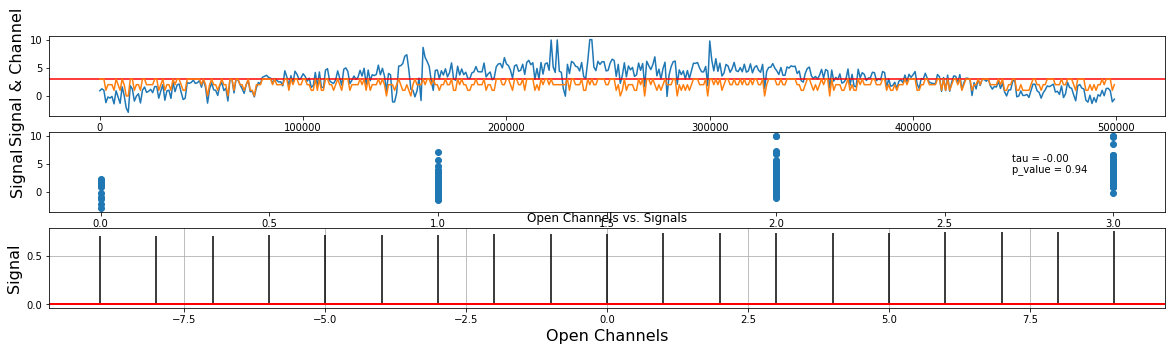

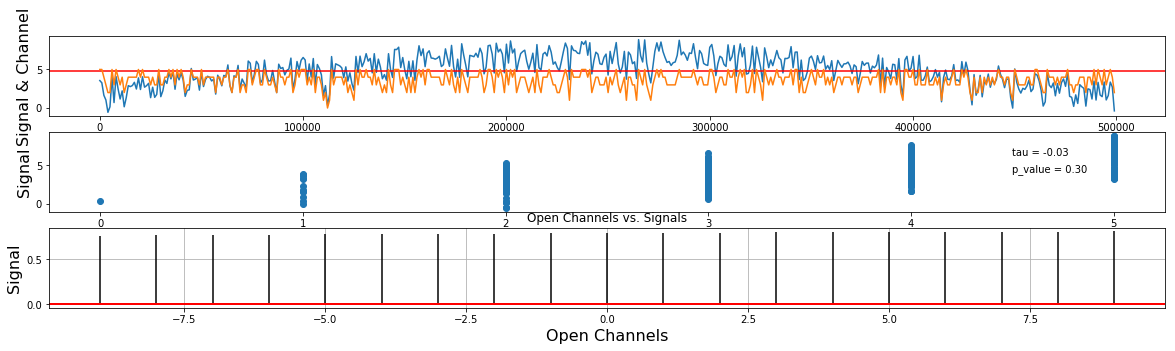

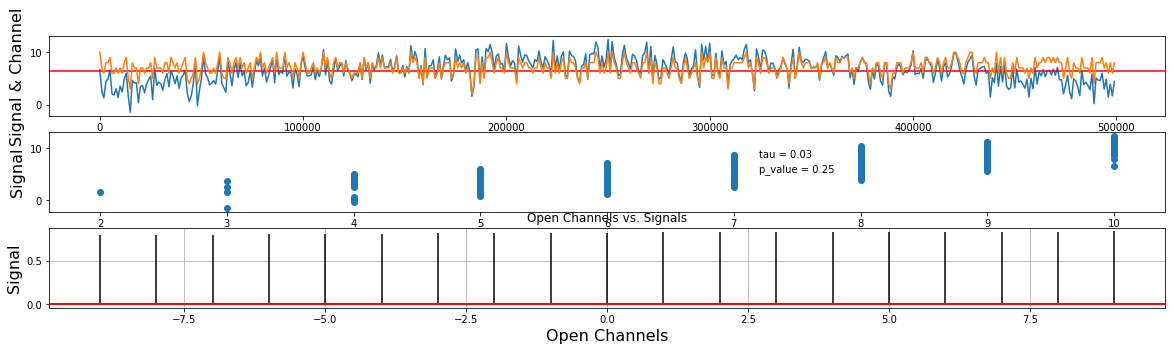

In [15]:
import scipy.stats as stats


for i in train.batch.unique():
    plt.figure(figsize=(20,5)); 
    step = 1000

    batch_num = i
    mean = train[train.batch==batch_num].signal.mean()
    std = train[train.batch==batch_num].signal.std()
    
    x1 = range(0,500000,step)
    x2 = train[train.batch==batch_num].open_channels[0::step]
    y1 = train[train.batch==batch_num].signal[0::step]
    y2 = mean
    y3 = train[train.batch==batch_num].open_channels[0::step]

    plt.subplot(3, 1, 1)
    plt.plot(x1,y1)
    plt.axhline(y=y2, color='r', linestyle='-')
    plt.plot(x1,y3)
    plt.xlabel('Row',size=16); 
    plt.ylabel('Signal & Channel',size=16);
    
    plt.subplot(3, 1, 2)
    tau, p_value = stats.kendalltau(x1, y1)
    tau
    p_value
    plt.text((max(x2)-min(x2))*.9,(max(y1)+min(y1))*.5,'p_value = %.2f ' %p_value, fontsize = 10)
    plt.text((max(x2)-min(x2))*.9,(max(y1)+min(y1))*.75,'tau = %.2f ' %tau, fontsize = 10)
    plt.scatter(x2,y1)
    plt.xlabel('Open Channels',size=16); 
    plt.ylabel('Signal',size=16);
    
    plt.subplot(3, 1, 3)
    lines = plt.xcorr(x1, y1, maxlags=9, usevlines=True)
    plt.title('Open Channels vs. Signals')
    plt.xlabel('Open Channels',size=16); 
    plt.ylabel('Signal',size=16); 
    plt.grid(True)
    plt.axhline(0, color='red', lw=2)
    plt.show()
                            


From the above graphs, we can see that open channels appears to be correlated with the signal, as the open channels go up when the signal goes up and down when the signal goes down.

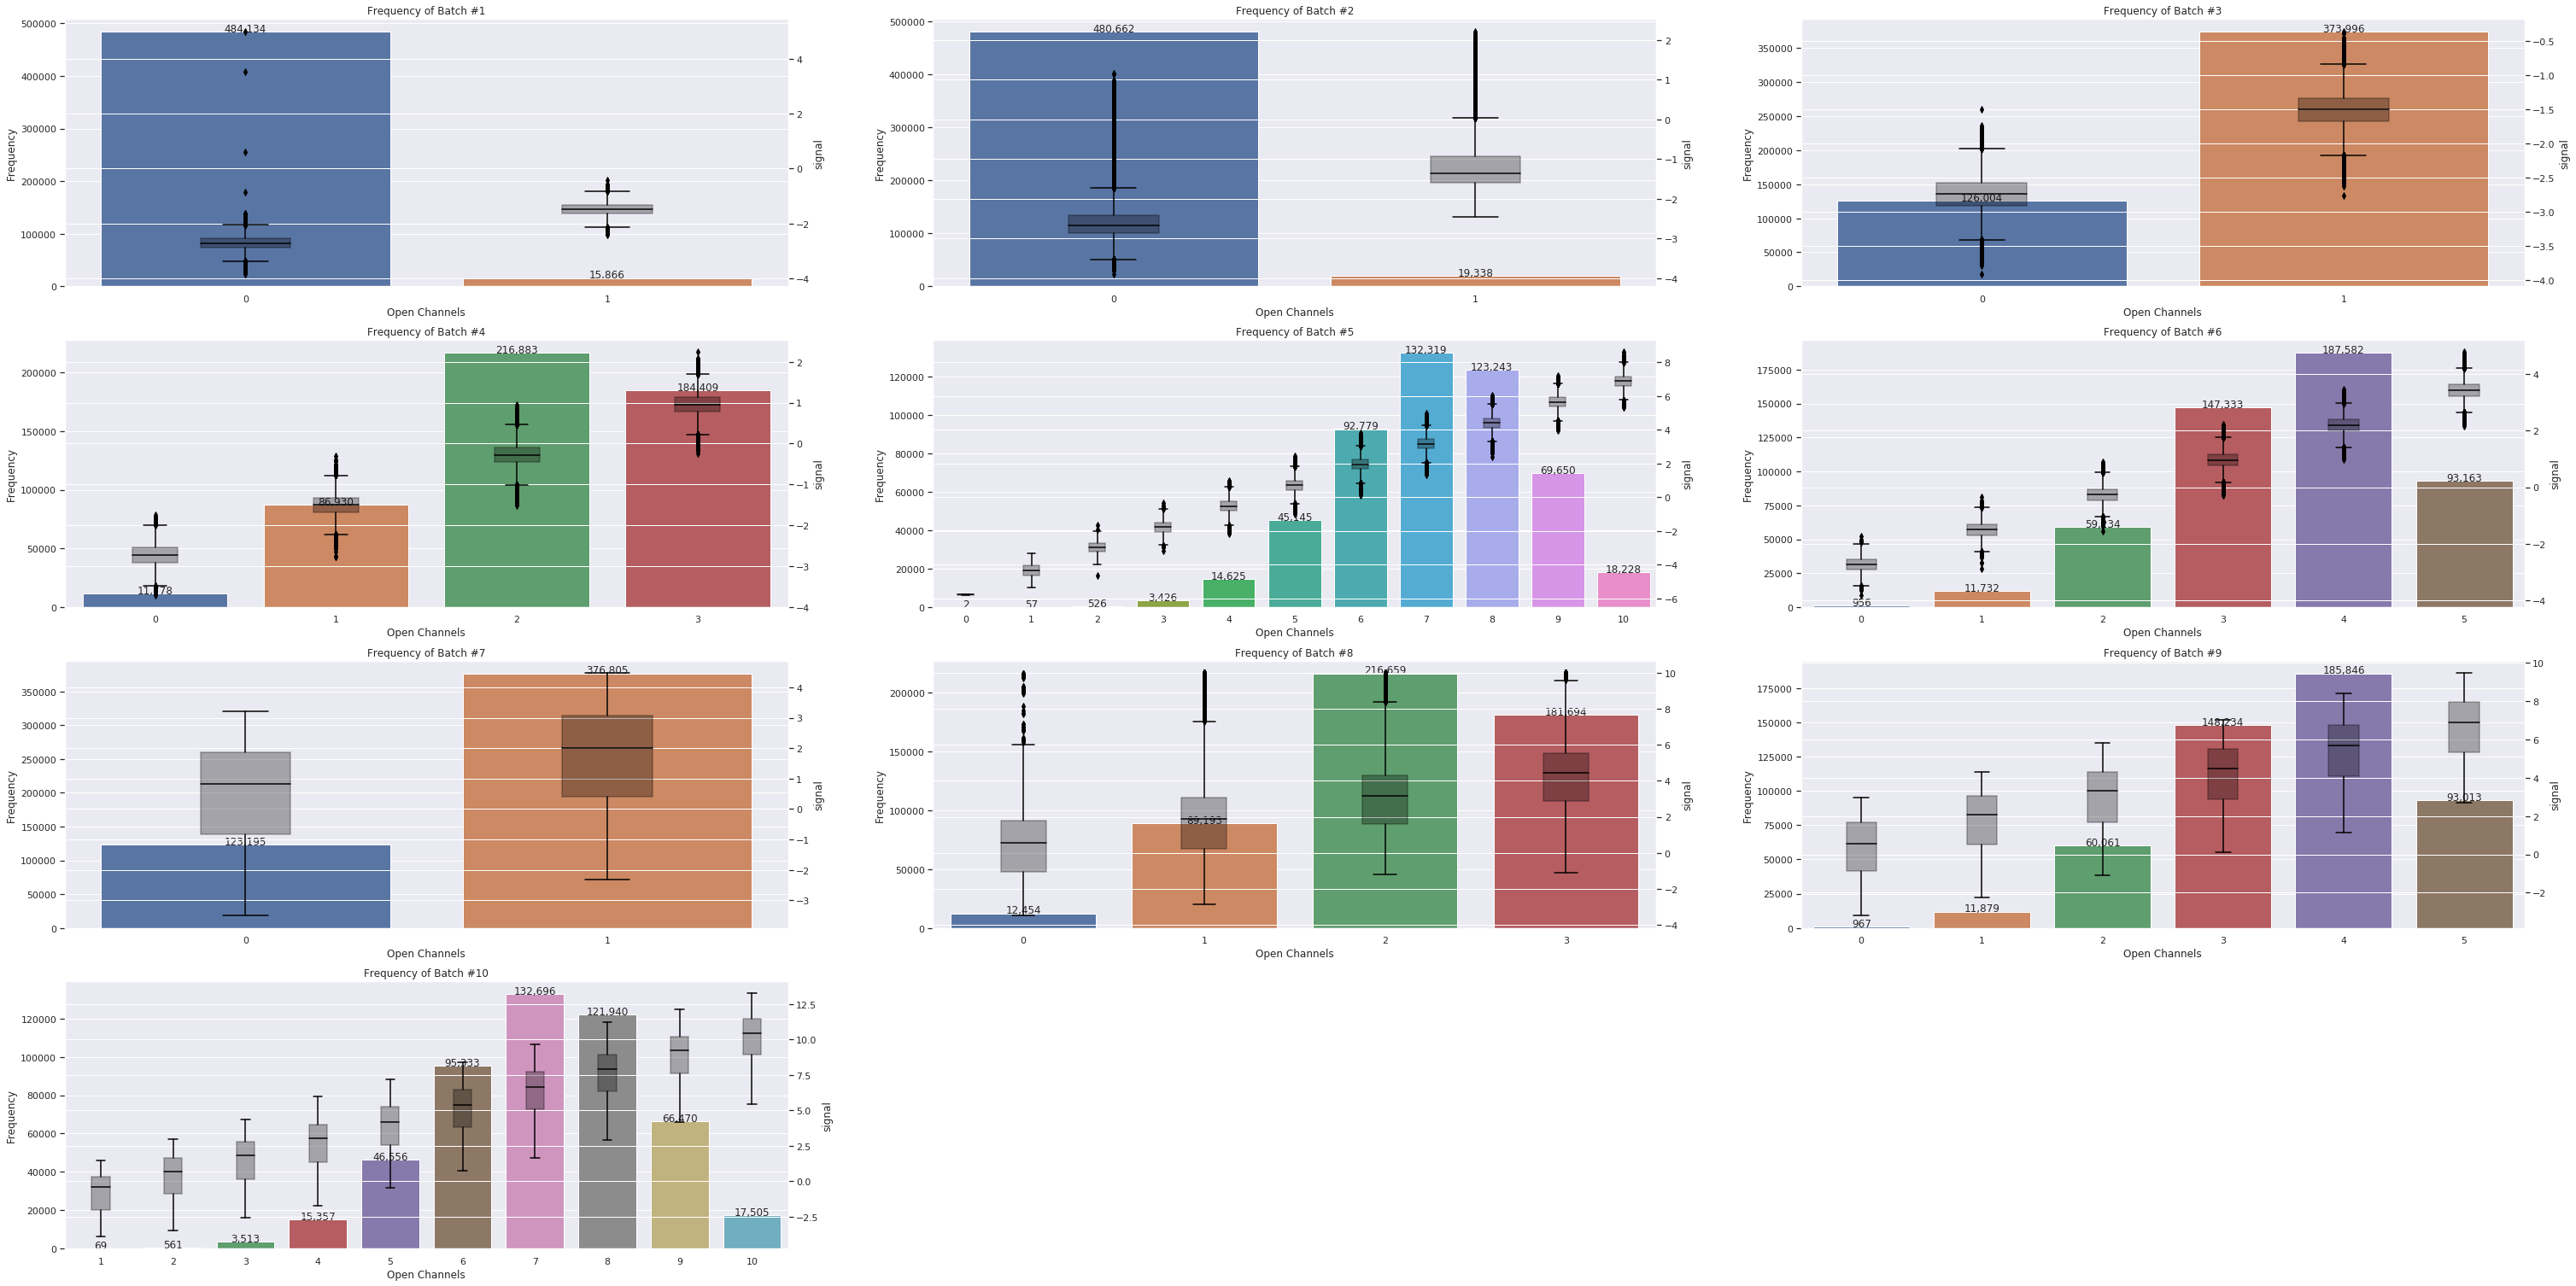

In [16]:
fig=plt.figure(figsize=(20,20))
sns.set(style="darkgrid")

for i in train.batch.unique():
    plt.subplot(4, 3, i)
    plt.subplots_adjust(left=2, bottom=2, right=4, top=3, wspace=None, hspace=None)
    y1 = train[train.batch ==i].open_channels
    df = train[train.batch==i]
    ax = sns.countplot(y1)
    ax.set(xlabel='Open Channels', ylabel='Frequency', title='Frequency of Batch #{}'.format(i))
    for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x()+.4, p.get_height()+1), ha = 'center')
       
    ax2 = ax.twinx()
    sns.boxplot(x=df.open_channels, y = df.signal, ax = ax2, boxprops=dict(alpha=.3), color = 'black', width = .25)


plt.show()

## Feature Engineering Manual****

In [17]:
from scipy.signal import butter,filtfilt,freqz

batch_size = 500000
num_batches = 10
res = 1000 # Resolution of signal plots

fs = 10000       # sample rate, 10kHz
nyq = 0.5 * fs  # Nyquist Frequency
cutoff_freq_sweep = range(250,4750,50) # Sweeping from 250 to 4750 Hz for SNR measurement
lpf_cutoff = 600
order = 20  

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
batch = 8

signal_lpf_batch_8 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

In [ ]:
signal_lpf_batch_8

In [ ]:
train[train.batch ==8].signal

In [ ]:
plt.plot(signal_lpf_batch_8)

In [ ]:
plt.plot(train[train.batch ==8].signal)

In [43]:
def feature_engineering(dataset):
    engineered_df = pd.DataFrame([])
    for i in dataset.batch.unique():
        temp = dataset[dataset.batch == i]
        temp['mean_signal_ratio'] = temp.signal / temp.signal.mean()
        temp['std_signal_ratio'] = temp.signal / temp.signal.std()
        temp['max_signal_ratio'] = temp.signal / temp.signal.max()
        temp['min_signal_ratio'] = temp.signal / temp.signal.min()
        temp['range_signal_ratio'] = temp.signal / temp.signal.max()-dataset.signal.min()
        temp['median_signal_ratio'] = temp.signal / temp.signal.median()
        
        temp['last5']=temp.groupby('batch').signal.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
        temp['last5_ratio'] = temp.signal / temp.last5
        engineered_df = engineered_df.append(temp,ignore_index=True)
    return engineered_df

In [52]:
final_train = feature_engineering(train_clean)
final_test = feature_engineering(test_clean)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [49]:
final_train.groupby('batch').agg({'signal': [np.mean],
                            'mean_signal_ratio':[np.mean],
                           'std_signal_ratio':[np.mean],
                             'max_signal_ratio':[np.mean],
                          'min_signal_ratio':[np.mean],
                          'range_signal_ratio':[np.mean],
                          'median_signal_ratio':[np.mean]})

,signal,mean_signal_ratio,std_signal_ratio,max_signal_ratio,min_signal_ratio,range_signal_ratio,median_signal_ratio
,mean,mean,mean,mean,mean,mean,mean
batch,,,,,,,
1,-2.681406,1.0,-8.134585,-0.536303,0.696361,5.260197,0.989522
2,-2.683105,1.0,-7.764952,-9.015810,0.687605,-3.219310,0.987047
3,-1.813125,1.0,-3.071174,5.143617,0.463632,10.940117,1.126095
4,-0.092984,1.0,-0.092725,-0.041503,0.025081,5.754997,0.693909
5,3.357808,1.0,1.846710,0.389849,-0.579282,6.186349,0.989745
6,1.680843,1.0,1.314537,0.350694,-0.440311,6.147194,0.876398
7,-1.803928,1.0,-3.077368,6.319627,0.462281,12.116127,1.123222
8,-0.107861,1.0,-0.092152,-0.021573,0.021572,5.774927,0.822767


### BUILD MODEL

In [31]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


Encode the Output Variable and Normalize the input matrix.

In [53]:
# Label the output variables
encoder = LabelEncoder()
target = final_train.open_channels
encoder.fit(target)
encoded_target = encoder.transform(target)
encoded_target = np_utils.to_categorical(encoded_target) #1 hot encode output variales

final_train = final_train.drop(['open_channels','time','batch'], axis=1).values
final_train = preprocessing.normalize(final_train)

final_test = final_test.drop(['time','batch'], axis=1).values
final_test = preprocessing.normalize(final_test)


Add Early Stopper

In [57]:
from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='accuracy', min_delta=0,
                             patience=1, verbose=1, mode='auto')



In [58]:
def baseline_neural_network(learning_rate =.1):
    #Create Model
    model = Sequential()
    model.add(Dense(10, input_dim=9, activation='relu'))
    #model.add(Dense(10, input_dim=7, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    opt = Adam(lr = learning_rate)
    model.summary()
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"]    ) 
    #Compile Model
    #model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'], verbose = 1)
    return model

In [59]:
estimator = KerasClassifier(build_fn=baseline_neural_network, epochs = 3)

Evaluate the model with k-Fold Cross Validation

In [60]:
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, final_train, encoded_target, cv = kfold, fit_params={'callbacks':[earlystopper]})
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                100       
_________________________________________________________________
dense_6 (Dense)              (None, 11)                121       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2500000/2500000 [==============================] - 118s 47us/step - loss: 0.2441 - accuracy: 0.9267
Epoch 2/3
2500000/2500000 [==============================] - 116s 46us/step - loss: 0.2273 - accuracy: 0.9304
Epoch 3/3
2500000/2500000 [==============================] - 115s 46us/step - loss: 0.2260 - accuracy: 0.9296
Epoch 00003: early stopping
2500000/2500000 [==============================] - 57s 23us/step
Model: "sequential_4"
_________________________________________________________________
Layer (

## Predict Test Data

In [62]:
estimator.fit(final_train, encoded_target)
prediction = estimator.predict(final_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                100       
_________________________________________________________________
dense_12 (Dense)             (None, 11)                121       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
5000000/5000000 [==============================] - 238s 48us/step - loss: 0.2540 - accuracy: 0.9256
Epoch 2/3
5000000/5000000 [==============================] - 231s 46us/step - loss: 0.2475 - accuracy: 0.9284
Epoch 3/3
5000000/5000000 [==============================] - 235s 47us/step - loss: 0.2454 - accuracy: 0.9281


## Export Submission

In [64]:
submission['open_channels'] =  prediction

submission.to_csv('submission.csv', index=False, float_format='%.4f')


,time,open_channels
0,500.0001,1
1,500.0002,1
2,500.0003,1
3,500.0004,1
4,500.0005,1
5,500.0006,1
6,500.0007,1
7,500.0008,1
8,500.0009,1
9,500.0010,1


In [69]:
submission.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 2 columns):
time             float64
open_channels    int64
dtypes: float64(1), int64(1)
memory usage: 30.5 MB
